In [1]:
import GenStateChain as GSC
import numpy as np
import scipy.constants as consts
import arc

In [2]:
GSC.set_n([5])
# 5 states
# 0 - F = 1
# 1 - F = 2
# 2 - F' = 2
# 3 - F' = 3
# 4 - Rydberg

In [72]:
atom = arc.Sodium()

PDown = 10e-6 # units are W
PUp = 30e-3
wDown = 100e-6 # units are m
wUp = 100e-6

tdme_ge = atom.getDipoleMatrixElementHFS(3, 0, 0.5, 2, 2, 3, 1, 1.5, 3, 3, +1, s=0.5)
dipole_ge = tdme_ge* consts.e * consts.physical_constants["Bohr radius"][0]
maxIntensity_ge = 2 * PDown / (np.pi * wDown**2)
electricField_ge = np.sqrt(2.0 * maxIntensity_ge / (consts.c * consts.epsilon_0))
OmegaDown = 1e-6*electricField_ge * abs(dipole_ge) / consts.hbar

tdme_er = atom.getDipoleMatrixElementHFS(3, 1, 1.5, 3, 3, 39, 0, 1/2, 2, 2, -1, s=0.5)
dipole_er = tdme_er* consts.e * consts.physical_constants["Bohr radius"][0]
maxIntensity_er = 2 * PUp / (np.pi * wUp**2)
electricField_er = np.sqrt(2.0 * maxIntensity_er / (consts.c * consts.epsilon_0))
OmegaUp = 1e-6*electricField_er * abs(dipole_er) / consts.hbar

print('OmegaUp: ' + str(OmegaUp / (2 * np.pi)) + ', OmegaDown: ' + str(OmegaDown/(2* np.pi)))


Delta = 2 * np.pi * 100 # Single photon detuning
delta = 0 # Two photon detuning
#OmegaDown = 2 * np.pi * 22 # Rabi frequency for lower leg
#OmegaUp = 2 * np.pi * 16 # Rabi frequency for upper leg
GammaE = 1e-6 / atom.getStateLifetime(3, 1, 1.5, temperature=300.0, includeLevelsUpTo=3+10) # Decay rate of the intermediate state
GammaRyd = 1e-6 / atom.getStateLifetime(39, 0, 0.5, temperature=300.0, includeLevelsUpTo=39+10) # Decay rate of the Rydberg state
#GammaE = 0
#GammaRyd = 0
impurityDown = 0
impurityUp = 0

E0 = 0
E1 = 0
E2 = -Delta - 58 # Units of MHz
E3 = -Delta 
E4 = -delta -0.25*((OmegaUp**2)/(Delta)-(OmegaDown**2)/(Delta)) # Account for differential light shift

# Establish the diagonal first
HEnergy = E0 * GSC.Operators.proj([0]) + E1 * GSC.Operators.proj([1]) + E2 * GSC.Operators.proj([2]) + E3 * GSC.Operators.proj([3]) + E4 * GSC.Operators.proj([4])

# Establish the drive
HDriveDown = np.sqrt(impurityDown) * OmegaDown/2 * GSC.Operators.sigmax([0], [[1,2]]) + np.sqrt(1 - impurityDown) * OmegaDown/2 * GSC.Operators.sigmax([0], [[1,3]])
HDriveUp = np.sqrt(impurityUp) * OmegaUp/2 * GSC.Operators.sigmax([0], [[2,4]]) + np.sqrt(1 - impurityUp) * OmegaUp/2 * GSC.Operators.sigmax([0], [[3,4]]) 
#HDriveDown = OmegaDown/2 * GSC.Operators.sigmax([0], [[1,3]])
#HDriveUp = OmegaUp/2 * GSC.Operators.sigmax([0], [[3,4]]) 

# Establish the jump operators
c2 = np.sqrt(GammaE) * GSC.Operators.jump([[0,2]]) # Assume all decay out of this state goes to state 0 the dark state
c3 = np.sqrt(GammaE) * GSC.Operators.jump([[1,3]]) # Assume all decay out of this state goes to state 1
c4 = np.sqrt(GammaRyd/2) * GSC.Operators.jump([[2,4]]) + np.sqrt(GammaRyd/2) * GSC.Operators.jump([[3,4]]) # Assume half decay to each intermediate state

# Measurement operators
proj0 = GSC.Operators.proj([0])
proj1 = GSC.Operators.proj([1])
proj2 = GSC.Operators.proj([2])
proj3 = GSC.Operators.proj([3])
proj4 = GSC.Operators.proj([4])

OmegaUp: 0.0, OmegaDown: 22.12811310056903


In [4]:
# Simulation

# init_state
init_state = GSC.States.specify([1])

#end time
tend = 3
n_points = 100

HTot = HEnergy + HDriveDown + HDriveUp
result = GSC.Dynamics.MasterEq(HTot, init_state, 3, 1000, jump_ops = [c2,c3,c4], expects = [proj0,proj1,proj2,proj3,proj4], names=['0', '1', '2', '3', '4'], bPlot = False)

In [12]:
def simulate(PDown, wDown, PUp, wUp, Delta, delta, impurityDown =0, impurityUp = 0, tend = 3, n_points=100, bPlot=False):
    atom = arc.Sodium()

    PDown = PDown # units are W
    PUp = PUp
    wDown = wDown # units are m
    wUp = wUp
    
    tdme_ge = atom.getDipoleMatrixElementHFS(3, 0, 0.5, 2, 2, 3, 1, 1.5, 3, 3, +1, s=0.5)
    dipole_ge = tdme_ge* consts.e * consts.physical_constants["Bohr radius"][0]
    maxIntensity_ge = 2 * PDown / (np.pi * wDown**2)
    electricField_ge = np.sqrt(2.0 * maxIntensity_ge / (consts.c * consts.epsilon_0))
    OmegaDown = 1e-6*electricField_ge * abs(dipole_ge) / consts.hbar
    
    tdme_er = atom.getDipoleMatrixElementHFS(3, 1, 1.5, 3, 3, 39, 0, 1/2, 2, 2, -1, s=0.5)
    dipole_er = tdme_er* consts.e * consts.physical_constants["Bohr radius"][0]
    maxIntensity_er = 2 * PUp / (np.pi * wUp**2)
    electricField_er = np.sqrt(2.0 * maxIntensity_er / (consts.c * consts.epsilon_0))
    OmegaUp = 1e-6*electricField_er * abs(dipole_er) / consts.hbar
    
    print('OmegaUp: ' + str(OmegaUp / (2 * np.pi)) + ' MHz, OmegaDown: ' + str(OmegaDown/(2* np.pi)) + ' MHz')
    
    
    Delta = Delta # Single photon detuning
    delta = delta # Two photon detuning
    #OmegaDown = 2 * np.pi * 22 # Rabi frequency for lower leg
    #OmegaUp = 2 * np.pi * 16 # Rabi frequency for upper leg
    GammaE = 1e-6 / atom.getStateLifetime(3, 1, 1.5, temperature=300.0, includeLevelsUpTo=3+10) # Decay rate of the intermediate state
    GammaRyd = 1e-6 / atom.getStateLifetime(39, 0, 0.5, temperature=300.0, includeLevelsUpTo=39+10) # Decay rate of the Rydberg state
    #GammaE = 0
    #GammaRyd = 0
    impurityDown = impurityDown
    impurityUp = impurityUp

    print('OmegaRabi: ' + str(OmegaUp * OmegaDown / (2 * Delta) / (2 * np.pi)))

    E0 = 0
    E1 = 0
    E2 = -Delta - 58 # Units of MHz
    E3 = -Delta 
    E4 = -delta -0.25*((OmegaUp**2)/(Delta)-(OmegaDown**2)/(Delta)) # Account for differential light shift
    
    # Establish the diagonal first
    HEnergy = E0 * GSC.Operators.proj([0]) + E1 * GSC.Operators.proj([1]) + E2 * GSC.Operators.proj([2]) + E3 * GSC.Operators.proj([3]) + E4 * GSC.Operators.proj([4])
    
    # Establish the drive
    HDriveDown = np.sqrt(impurityDown) * OmegaDown/2 * GSC.Operators.sigmax([0], [[1,2]]) + np.sqrt(1 - impurityDown) * OmegaDown/2 * GSC.Operators.sigmax([0], [[1,3]])
    HDriveUp = np.sqrt(impurityUp) * OmegaUp/2 * GSC.Operators.sigmax([0], [[2,4]]) + np.sqrt(1 - impurityUp) * OmegaUp/2 * GSC.Operators.sigmax([0], [[3,4]]) 
    #HDriveDown = OmegaDown/2 * GSC.Operators.sigmax([0], [[1,3]])
    #HDriveUp = OmegaUp/2 * GSC.Operators.sigmax([0], [[3,4]]) 
    
    # Establish the jump operators
    c2 = np.sqrt(GammaE) * GSC.Operators.jump([[0,2]]) # Assume all decay out of this state goes to state 0 the dark state
    c3 = np.sqrt(GammaE) * GSC.Operators.jump([[1,3]]) # Assume all decay out of this state goes to state 1
    c4 = np.sqrt(GammaRyd/2) * GSC.Operators.jump([[2,4]]) + np.sqrt(GammaRyd/2) * GSC.Operators.jump([[3,4]]) # Assume half decay to each intermediate state
    
    # Measurement operators
    proj0 = GSC.Operators.proj([0])
    proj1 = GSC.Operators.proj([1])
    proj2 = GSC.Operators.proj([2])
    proj3 = GSC.Operators.proj([3])
    proj4 = GSC.Operators.proj([4])

    # init_state
    init_state = GSC.States.specify([1])
    
    HTot = HEnergy + HDriveDown + HDriveUp
    result = GSC.Dynamics.MasterEq(HTot, init_state, tend, n_points, jump_ops = [c2,c3,c4], expects = [proj0,proj1,proj2,proj3,proj4], names=['0', '1', '2', '3', '4'], bPlot = bPlot)

    return result

OmegaUp: 2.1995073266794796, OmegaDown: 69.97523771960871
OmegaRabi: 0.7695552402520881


Text(0.5, 1.0, '589: 100.00 uW, 100.00 um; 409: 9.00 mW, 100.00 um; $\\Delta=100.00$ MHz')

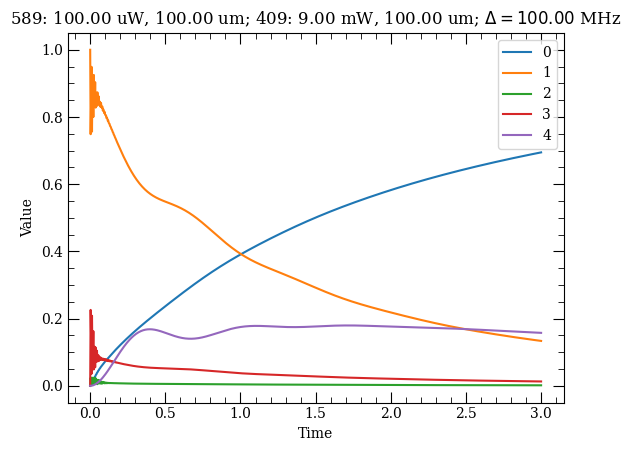

In [130]:
npoints = 11

PDown = 100e-6 # units are W
PUp = 30e-3 * 0.3
wDown = 100e-6 # units are m
wUp = 100e-6
Delta = 2 * np.pi * 100 # Single photon detuning
impurityDown = 0.1
impurityUp = 0.1
t = 3

result = simulate(PDown, wDown, PUp, wUp, Delta, 0, impurityDown = impurityDown, impurityUp = impurityUp, tend = t, n_points=1000, bPlot=True)
plt.title('589: %.2f uW, %.2f um; 409: %.2f mW, %.2f um; $\Delta=%.2f$ MHz' % (PDown * 1e6, wDown * 1e6, PUp * 1e3, wUp * 1e6, Delta / (2*np.pi)))

In [128]:
dets = np.linspace(-1,1,31) 
vals = []
t = 1.15
for det in dets:
    result = simulate(PDown, wDown, PUp, wUp, Delta, 2 * np.pi * det, impurityDown = impurityDown, impurityUp = impurityUp, tend = t, n_points=100)
    vals.append(result.expect[4][-1])

OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, OmegaDown: 38.32701616581606
OmegaRabi: 0.4215027643323764
OmegaUp: 2.1995073266794796, Ome

Text(0.5, 1.0, '589: 30.00 uW, 100.00 um; 409: 9.00 mW, 100.00 um; $\\Delta=100.00$ MHz, t=1.15 us')

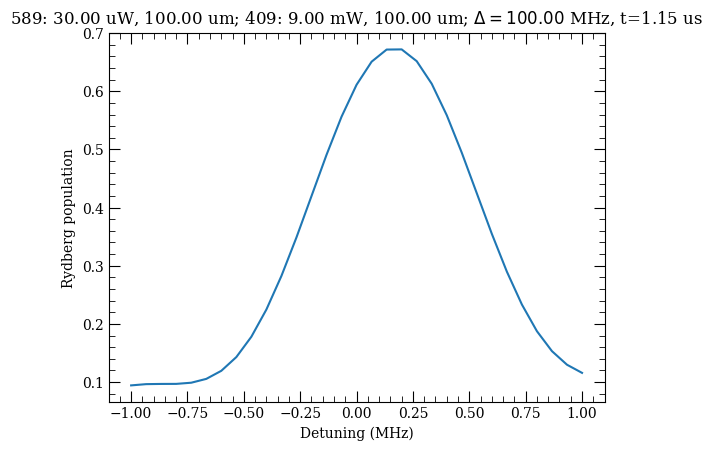

In [129]:
from matplotlib import pyplot as plt
plt.plot(dets, vals)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Rydberg population')
plt.title('589: %.2f uW, %.2f um; 409: %.2f mW, %.2f um; $\Delta=%.2f$ MHz, t=%.2f us' % (PDown * 1e6, wDown * 1e6, PUp * 1e3, wUp * 1e6, Delta / (2*np.pi), t))

In [53]:
atom.getDipoleMatrixElementHFS(3, 0, 0.5, 2, 2, 3, 1, 1.5, 3, 3, 1, s=0.5)

0.0

In [58]:
OmegaDown /(2* np.pi)

22.12811310056903

In [59]:
OmegaUp / ( 2* np.pi)

1212.0066700207246

In [43]:
HDriveDown

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         69.51751755  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.         69.51751755  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]

In [56]:
consts.c / (2 * 0.015) / 1e9

9.993081933333334